In [101]:
#from statsmodels.tsa.arima_process import ArmaProcess 
#from statsmodels.tsa.stattools import pacf, acf
#from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf
import Extreme_functions as ef


from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb

plt.rcParams["figure.figsize"] = (20,10)

In [102]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


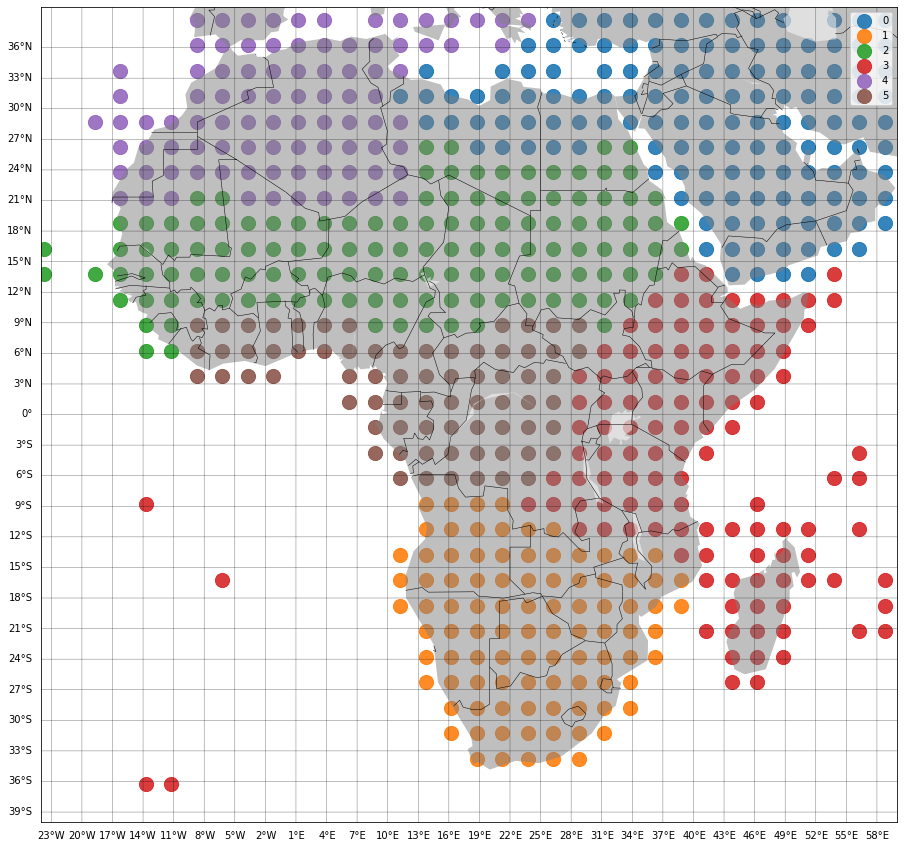

In [103]:
n_components = 6

d = Data('../precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

result = pd.DataFrame(result)
result = pf.deseasonalize(np.array(result))
#result = np.array(result)

temp = np.array(result)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

clusters = clustering.labels_

df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
m.drawcountries()
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

plt.savefig("../plots/clusters.png")  
plt.legend()
plt.show()

In [144]:
countries_1 = ['NA', 'BW','ZA','ZM','ZW','AO','MZ','LS']
countries_3 = ['ET','SO','KE','TZ','MG','UG','DJ']
countries_5 = ['CD','CG','CM','GA','CF','TG','GH', 'CI']
countries_2 = ['SD','TD','NE','NG','ML','MR','SN','GN','BJ','BF','SL','LR']
countries_4 = ['DZ','MA','TN']
countries_0 = ['LY','EG','IL','IQ','IR','JO','LB','SY','SA','AE','YE','OM','QA','KW']

In [145]:
countries = []

In [151]:
countries.append(countries_5)

In [132]:
rolling_n = 12
extreme_type = 'dry'
indicator='SP.POP.TOTL'
cluster = 1

In [137]:
def IID_plot(cluster, countries_code):   
    file_name = "Data_{}.csv".format(cluster)
    et = pd.read_csv(file_name)
    et  = et.iloc[:,[0,4]]
    et  = et.dropna()
    et["year"] = pd.to_numeric(et["year"])
    df_oni = ef.extreme_plot(cluster,12)

    df_oni = df_oni.iloc[1:,:]

    N = df_oni.shape[0]

    df_oni = df_oni.rolling(12).sum()

    Idx = np.arange(11,N,12)

    df_oni = df_oni.iloc[Idx,:]

    year = np.arange(1977,2016)

    df_oni["year"] = year

    df = df_oni.merge(et, how = 'left')

    df = df.fillna(0)

    df = df.drop(["oni"], axis=1)


    dat = wb.download(indicator=indicator, country=countries_code, start=1940, end=2019)

    year = np.arange(2019,1959, -1)

    #df = pd.DataFrame({"year":year,"POP":dat["SP.POP.TOTL"].values})

    N = len(dat[indicator].keys())



    years = []
    countries = []
    for i in range(N):
        countries.append(dat[indicator].keys()[i][0])
        years.append(dat[indicator].keys()[i][1])

    years = list(set(years))
    countries = list(set(countries))

    result = []
    for year in years:
        temp = 0
        for country in countries:
            temp += dat[indicator][(country, year)]
        result.append(temp)

    years = [ int(x) for x in years ]

    df_pop =pd.DataFrame({'year':years, 'pop':result})

    df = df.merge(df_pop, how='left')

    df['Affected'] = df['Affected']/df['pop']
    df = df.fillna(0)

    df = df.drop(["pop"], axis=1)

    df = df.set_index("year")

    df_norm = (df - df.mean())/df.std()

    title = "Cluster {} Cumulative rainfall {} months {} extremes".format(cluster,rolling_n, extreme_type)
    plot = df_norm.plot(figsize=(20,10), title = title, fontsize = 18).legend(fontsize = 18)
    fig = plot.get_figure()
    filename = "../plots/IDD/cluster_{}_{}.png".format(cluster, extreme_type)
    correlation = df_norm.corr()
    corr_text = "Correlation is {:.3f}".format(correlation.iloc[0,1])
    fig.text(0.1,0.9,corr_text,fontsize=18)
    fig.savefig(filename)
    return(df)

    #df_norm.plot()

    #df.corr()

In [183]:
cluster = 5

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/Extreme_functions.py:322: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  RFThree = r.rolling(rolling_n).apply(sum)


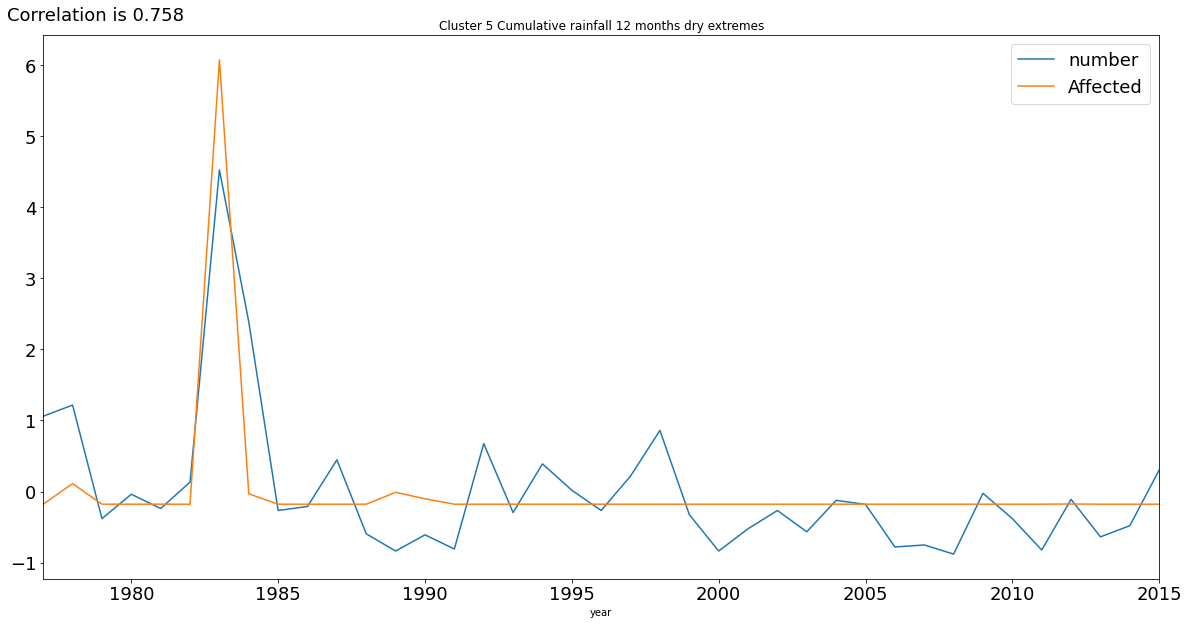

In [184]:
df = IID_plot(cluster, countries[cluster])

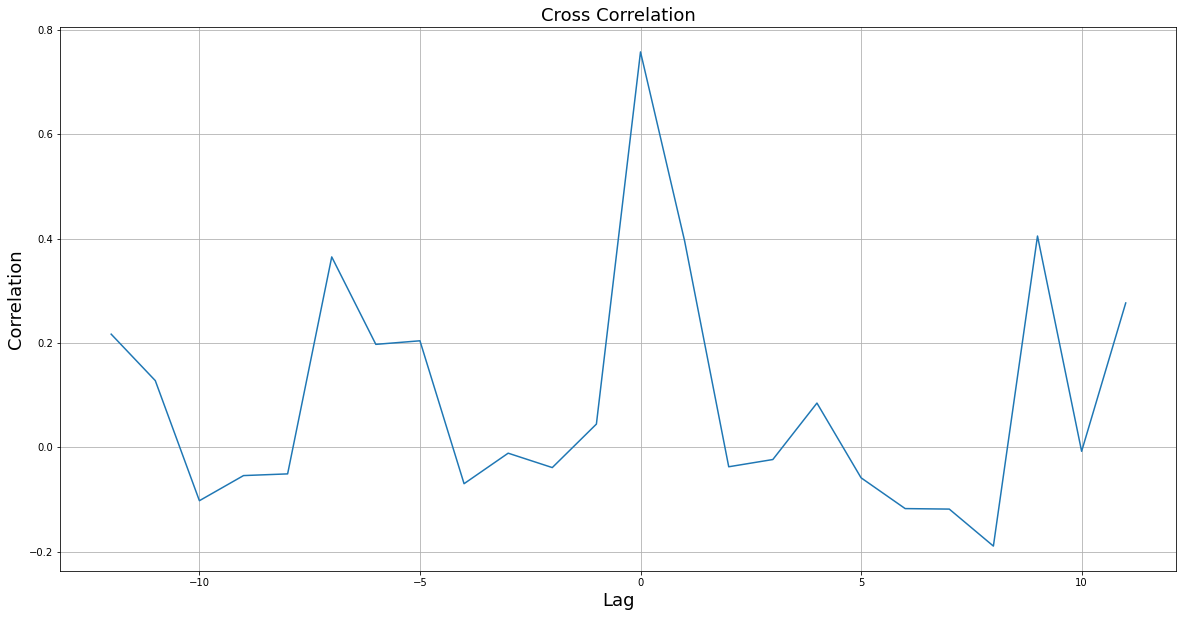

In [185]:
xcov_monthly = [ef.crosscorr(df["number"],df["Affected"],lag=i) for i in range(-12,12)]
lag = np.arange(-12,12)

fig = plt.figure()
plt.plot(lag, xcov_monthly)
plt.title("Cross Correlation", fontsize = 18)
plt.ylabel("Correlation", fontsize = 18)
plt.xlabel("Lag", fontsize = 18)
plt.grid()
filename = "../plots/IDD/Corr_{}.png".format(cluster)
fig.savefig(filename)

In [141]:
for i in range(-12,12):
    print("lag={}  cross-correlation:{}".format(i,xcov_monthly[i+12]))
    print(" ")

lag=-12  cross-correlation:-0.1389529085852239
 
lag=-11  cross-correlation:-0.12371750517015005
 
lag=-10  cross-correlation:0.0819296023662817
 
lag=-9  cross-correlation:0.07975958470612568
 
lag=-8  cross-correlation:0.08527227390546838
 
lag=-7  cross-correlation:-0.10211246366504648
 
lag=-6  cross-correlation:-0.10448576691537494
 
lag=-5  cross-correlation:-0.04647719271399055
 
lag=-4  cross-correlation:-0.15175345319654063
 
lag=-3  cross-correlation:-0.09111615053316274
 
lag=-2  cross-correlation:-0.11265605173768876
 
lag=-1  cross-correlation:-0.18845790094486617
 
lag=0  cross-correlation:0.15954020835276142
 
lag=1  cross-correlation:0.5998169528385783
 
lag=2  cross-correlation:0.2600341686924961
 
lag=3  cross-correlation:-0.06400142287648784
 
lag=4  cross-correlation:0.015159064994214618
 
lag=5  cross-correlation:-0.05259322984112039
 
lag=6  cross-correlation:-0.15240523872155104
 
lag=7  cross-correlation:-0.07801920696123618
 
lag=8  cross-correlation:-0.0535549

In [49]:
file_name = "Data_{}.csv".format(cluster)
et = pd.read_csv(file_name)
et  = et.iloc[:,[0,4]]
et  = et.dropna()
et["year"] = pd.to_numeric(et["year"])
df_oni = ef.extreme_plot(cluster,12)

df_oni = df_oni.iloc[1:,:]

N = df_oni.shape[0]

df_oni = df_oni.rolling(12).sum()

Idx = np.arange(11,N,12)

df_oni = df_oni.iloc[Idx,:]

year = np.arange(1977,2016)

df_oni["year"] = year

df = df_oni.merge(et, how = 'left')

df = df.fillna(0)

df = df.drop(["oni"], axis=1)

/home/mathsys2/Files/Time_Series/Climate_Network/Causality/TimeSeries/notebooks/Extreme_functions.py:322: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  RFThree = r.rolling(rolling_n).apply(sum)


Text(0.1, 0.9, 'Correlation is -0.068')

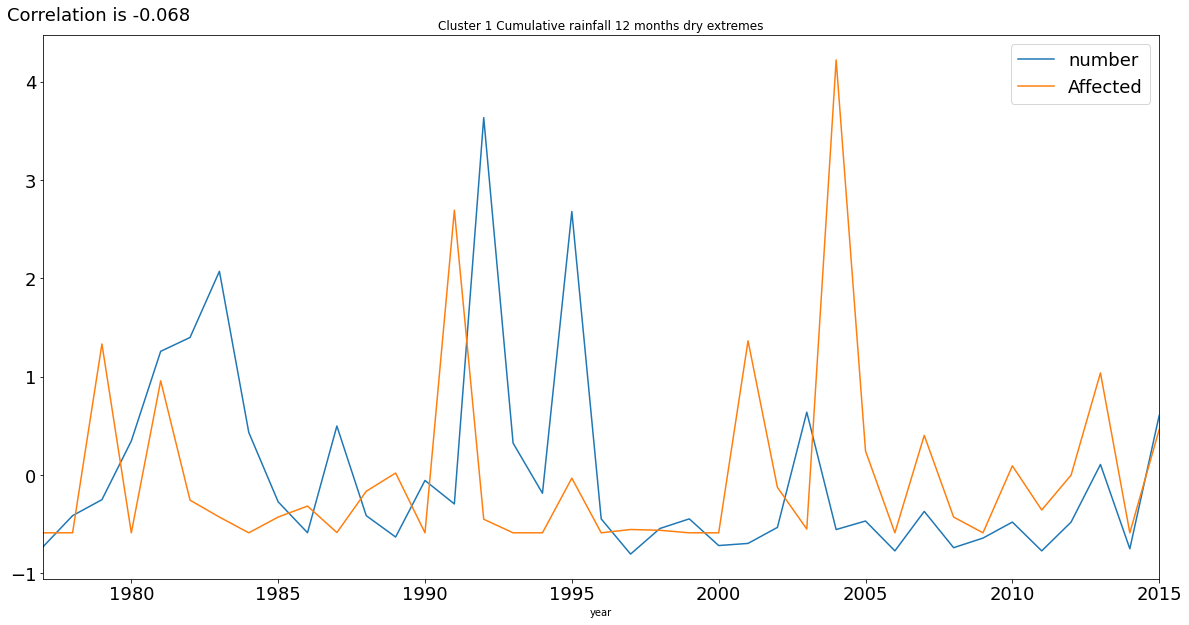

In [51]:
df = df.set_index("year")

df_norm = (df - df.mean())/df.std()

title = "Cluster {} Cumulative rainfall {} months {} extremes".format(cluster,rolling_n, extreme_type)
plot = df_norm.plot(figsize=(20,10), title = title, fontsize = 18).legend(fontsize = 18)
fig = plot.get_figure()
filename = "../plots/IDD/cluster_{}_{}.png".format(cluster, extreme_type)
correlation = df_norm.corr()
corr_text = "Correlation is {:.3f}".format(correlation.iloc[0,1])
fig.text(0.1,0.9,corr_text,fontsize=18)

In [29]:
dat = wb.download(indicator=indicator, country=['ET','SO','KE','TZ','MG','UG','DJ'], start=1940, end=2019)

year = np.arange(2019,1959, -1)

#df = pd.DataFrame({"year":year,"POP":dat["SP.POP.TOTL"].values})

N = len(dat[indicator].keys())



years = []
countries = []
for i in range(N):
    countries.append(dat[indicator].keys()[i][0])
    years.append(dat[indicator].keys()[i][1])

years = list(set(years))
countries = list(set(countries))

result = []
for year in years:
    temp = 0
    for country in countries:
        temp += dat[indicator][(country, year)]
    result.append(temp)

years = [ int(x) for x in years ]

df_pop =pd.DataFrame({'year':years, 'pop':result})

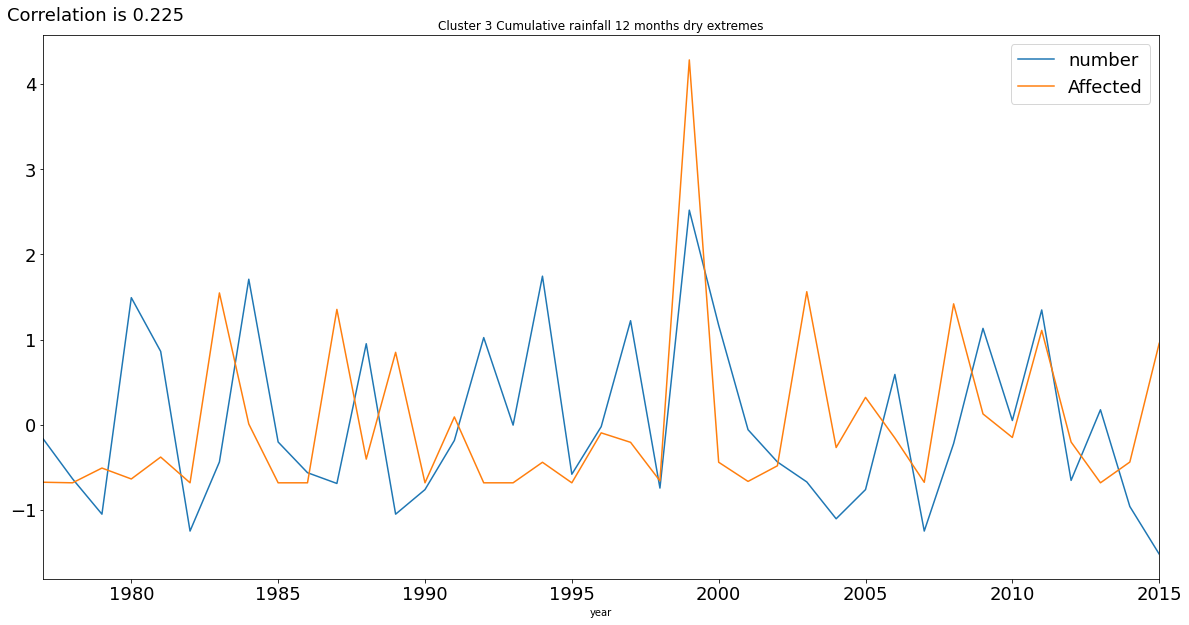

In [30]:
df = df.merge(df_pop, how='left')

df['Affected'] = df['Affected']/df['pop']

df = df.drop(["pop"], axis=1)

df = df.set_index("year")

df_norm = (df - df.mean())/df.std()

title = "Cluster {} Cumulative rainfall {} months {} extremes".format(cluster,rolling_n, extreme_type)
plot = df_norm.plot(figsize=(20,10), title = title, fontsize = 18).legend(fontsize = 18)
fig = plot.get_figure()
filename = "../plots/IDD/cluster_{}_{}.png".format(cluster, extreme_type)
correlation = df_norm.corr()
corr_text = "Correlation is {:.3f}".format(correlation.iloc[0,1])
fig.text(0.1,0.9,corr_text,fontsize=18)
fig.savefig(filename)

#df_norm.plot()

#df.corr()